In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade gspread
!pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import andrews_curves
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import accuracy_score
from google.colab import auth
import gspread
from google.auth import default
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

path_train = '/content/drive/MyDrive/Data/train_data.csv'
train_df = pd.read_csv(path_train)

path_val = '/content/drive/MyDrive/Data/val_data.csv'
val_df = pd.read_csv(path_val)

path_test = '/content/drive/MyDrive/Data/test_data.csv'
test_df = pd.read_csv(path_test)

Importing Libraries to set up the notebook, and getting the dataset ready to be used by the AI model.

In [ ]:
X = train_df.columns.difference(['diabetes'])
y = ['diabetes']

X_train = train_df[X]
print('X_train, our input variables:')
print(X_train.head())
print()

y_train = train_df[y]
print('y_train, our output variable:')
print(y_train.head())

X_train, our input variables:
   HbA1c_level   age  blood_glucose_level    bmi  gender  heart_disease  \
0          4.0  36.0                  145  17.06     1.0              0   
1          6.1  58.0                  159  37.83     0.0              0   
2          5.0  43.0                  160  39.20     0.0              0   
3          5.7  67.0                  159  28.39     1.0              0   
4          6.0   5.0                   80  27.32     0.0              0   

   hypertension  smoking_history_current  smoking_history_ever  \
0             0                        0                     0   
1             0                        0                     0   
2             0                        0                     0   
3             1                        0                     0   
4             0                        0                     0   

   smoking_history_former  smoking_history_never  smoking_history_not current  
0                       0                 

Setting up the model by mentioning which columns represent the input features and which column is the output label.

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)

In [ ]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train_imputed, y_train)

In [ ]:
X_val = val_df[X]
y_val = val_df[y]

In [ ]:
X_test = test_df[X]
y_test = test_df[y]

In [ ]:
scaler = StandardScaler()
X_adasyn_scaled = scaler.fit_transform(X_adasyn)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

The code uses a StandardScaler to standardize the features of two datasets, X_adasyn and X_val. The fit_transform method scales the training data (X_adasyn), while the transform method scales the validation data (X_val) using the parameters learned from the training data.

In [ ]:
# Convert pandas DataFrames to PyTorch tensors
X_adasyn_tensor = torch.tensor(X_adasyn_scaled, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
# Convert pandas DataFrames to PyTorch tensors
X_adasyn_tensor = torch.tensor(X_adasyn_scaled, dtype=torch.float32)
y_adasyn_tensor = torch.tensor(y_adasyn.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

The code converts the standardized datasets (X_adasyn_scaled, y_adasyn, X_val_scaled, y_val) into PyTorch tensors (X_adasyn_tensor, y_adasyn_tensor, X_val_tensor, y_val_tensor) with a specified data type of float32.

In [ ]:
class DiabetesPredictionModel(nn.Module):
    def __init__(self, input_size):
        super(DiabetesPredictionModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Flatten()
        )

        # Calculate the output size of the convolutional layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, input_size)
            conv_output_size = self._get_conv_output_size(dummy_input)

        self.linear_stack = nn.Sequential(
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )

    def _get_conv_output_size(self, x):
        x = self.conv_stack(x)
        return x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.conv_stack(x)
        logits = self.linear_stack(x)
        return logits

The code defines a neural network model (DiabetesPredictionModel) using PyTorch's nn.Module. It consists of convolutional layers followed by batch normalization, ReLU activation, and max pooling. The convolutional layers are then flattened, and the output is passed through fully connected layers with ReLU activation, dropout, and a final linear layer for binary classification. The model is designed for predicting diabetes based on input data with a specified size.

In [ ]:
# Define custom dataset for training and testing
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return len(self.X)

The code creates a PyTorch dataset class (DiabetesDataset) for managing input features (X) and labels (y). It includes methods for accessing individual items and obtaining the dataset's length.

In [ ]:
# Create data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)  # Add an extra dimension for input channels
test_dataset = DiabetesDataset(X_test_tensor.unsqueeze(1), y_val_tensor)  # Add an extra dimension for input channels
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

The code sets up PyTorch datasets (adasyn_dataset and val_dataset) and corresponding data loaders (adasyn_loader and val_loader). The input features are adjusted to include an additional dimension for input channels using unsqueeze(1). The DataLoader is configured with batch sizes and optional shuffling for the training dataset.

In [ ]:
# Creating data loaders for training and validation
adasyn_dataset = DiabetesDataset(X_adasyn_tensor.unsqueeze(1), y_adasyn_tensor)  # Add an extra dimension for input channels
test_dataset = DiabetesDataset(X_test_tensor.unsqueeze(1), y_test_tensor)  # Add an extra dimension for input channels
adasyn_loader = DataLoader(adasyn_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# Instantiating the model
input_size = X_adasyn_tensor.shape[1]
model = DiabetesPredictionModel(input_size)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000760, weight_decay=0.01)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5130609121, patience=9, verbose=True)

The code prepares data loaders for training and validation using PyTorch. It creates instances of a diabetes prediction model, defines a loss function, sets up an optimizer, and incorporates a learning rate scheduler for training.

In [ ]:
#Training and testing model
num_epochs = 5
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in adasyn_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets.squeeze())
        loss.backward()

        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(adasyn_dataset)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            test_loss += loss.item() * inputs.size(0)
    test_loss /= len(test_dataset)

    scheduler.step(test_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}")




Epoch 1/5, Train Loss: 0.1918, Val Loss: 0.1864
Epoch 2/5, Train Loss: 0.1596, Val Loss: 0.1459
Epoch 3/5, Train Loss: 0.1534, Val Loss: 0.1156
Epoch 4/5, Train Loss: 0.1484, Val Loss: 0.1685
Epoch 5/5, Train Loss: 0.1443, Val Loss: 0.1255


The code trains a diabetes prediction model for a specified number of epochs. It iterates through the training data, updates the model's weights based on the loss, and evaluates the model on the validation data.

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
    y_pred_val = (model(X_val_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

adasyn_accuracy = accuracy_score(y_adasyn, y_pred_adasyn)
val_accuracy = accuracy_score(y_val, y_pred_val)

print("ADASYN Accuracy:", adasyn_accuracy)
print("Val Accuracy:", val_accuracy)


ADASYN Accuracy: 0.9272221479852768
Val Accuracy: 0.9706


In [ ]:
model.eval()
with torch.no_grad():
    y_pred_adasyn = (model(X_adasyn_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()
    y_pred_test = (model(X_test_tensor.unsqueeze(1)) > 0.5).squeeze().numpy()

adasyn_accuracy = accuracy_score(y_adasyn, y_pred_adasyn)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("ADASYN Accuracy:", adasyn_accuracy)
print("Test Accuracy:", test_accuracy)


ADASYN Accuracy: 0.9272221479852768
Test Accuracy: 0.9688


The code uses a trained model to predict outcomes for two datasets (ADASYN and validation). It calculates accuracy scores by comparing the model predictions to the actual labels and prints the accuracy for both datasets.

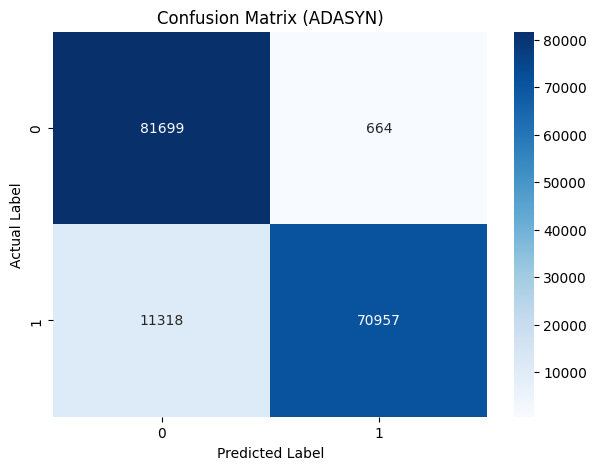

In [ ]:
cm = confusion_matrix(y_adasyn, y_pred_adasyn)
cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix (ADASYN)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy for predicting the diabetes label on the training set: (70957/82275) * 100 = 86.2%

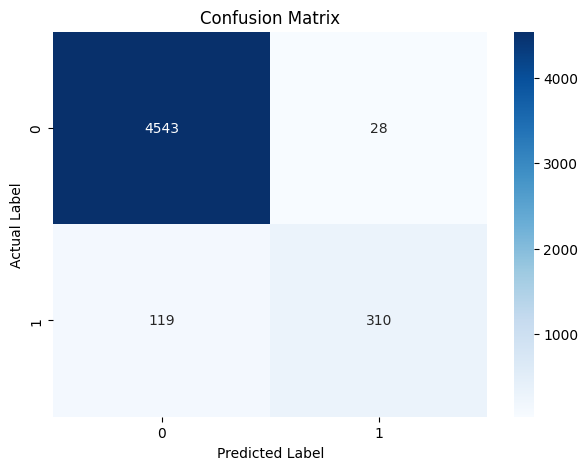

In [ ]:
cm = confusion_matrix(y_val, y_pred_val)

cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

Accuracy for predicting the diabetes label on the validation set: (310/429) * 100 = 72.3%

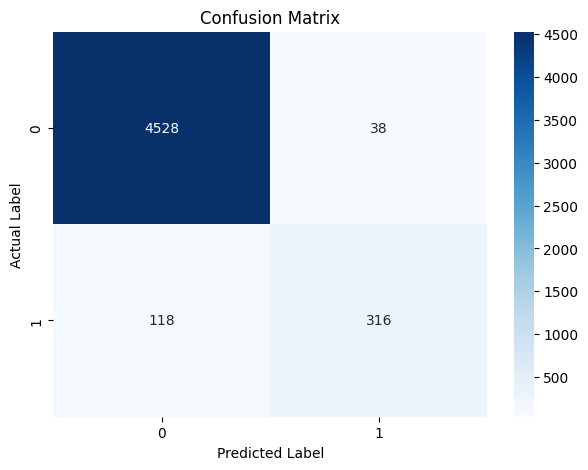

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

cm_df = pd.DataFrame(cm, index = [i for i in "01"], columns = [i for i in "01"])

plt.figure(figsize=(7,5))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

The accuracy for predicting the diabetes label on test set is: (316/434) * 100 = 72.8%

The code computes a confusion matrix using the predicted values (y_pred_val) and actual labels (y_val). It then visualizes the confusion matrix using a heatmap, providing an overview of the model's performance in terms of true positives, true negatives, false positives, and false negatives.